In [1]:
from google.colab import auth
auth.authenticate_user()


In [2]:
from google.cloud import bigquery

project_id = "ai-in-medicine-unihamburg"
client = bigquery.Client(project=project_id)

query = """
SELECT
    n.subject_id,
    n.hadm_id,
    ANY_VALUE(n.text) AS note_text,
    -- Aggregating all codes for this specific admission
    STRING_AGG(dx.icd_code, ', ') AS icd_codes,
    -- Aggregating all descriptions for this specific admission
    STRING_AGG(d.long_title, ' | ') AS icd_descriptions
FROM `physionet-data.mimiciv_note.discharge` AS n
JOIN `physionet-data.mimiciv_3_1_hosp.diagnoses_icd` AS dx
    ON n.hadm_id = dx.hadm_id
JOIN `physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses` AS d
    ON dx.icd_code = d.icd_code
WHERE dx.icd_version = 10
GROUP BY n.subject_id, n.hadm_id
-- This magic line ensures only 1 admission (hadm_id) per patient (subject_id)
QUALIFY ROW_NUMBER() OVER (PARTITION BY n.subject_id ORDER BY n.hadm_id ASC) = 1
LIMIT 100000
"""

df = client.query(query).to_dataframe()

print(df.head())
print(df.tail())

   subject_id   hadm_id                                          note_text  \
0    10010867  22196214   \nName:  ___               Unit No:   ___\n \...   
1    10030746  22297761   \nName:  ___                   Unit No:   ___...   
2    10033887  25791193   \nName:  ___                Unit No:   ___\n ...   
3    10036086  22023413   \nName:  ___.              Unit No:   ___\n \...   
4    10049041  22532814   \nName:  ___                Unit No:   ___\n ...   

                                           icd_codes  \
0  J90, I272, M25511, Z981, Z87820, V8609XS, Y924...   
1  I214, D62, I2510, Z87891, E785, I10, E119, K29...   
2                                F209, F17210, F1210   
3  I25110, B20, I1310, B181, Z6842, Z862, E119, Z...   
4  A419, J15211, J9622, J441, Z9911, J440, I82C11...   

                                    icd_descriptions  
0  Pleural effusion, not elsewhere classified | O...  
1  Non-ST elevation (NSTEMI) myocardial infarctio...  
2  Schizophrenia, unspecified

In [ ]:
!pip install -U langchain langchain-community chromadb sentence-transformers langchain-ollama


In [5]:
import os
import json
import warnings
from dotenv import load_dotenv
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings

# Setup
warnings.filterwarnings("ignore", category=DeprecationWarning)
load_dotenv('/content/llama.env') # Path in Colab


api_url = "https://dev.chat.cosy.bio/ollama"
llm_name = "llama3.1:8b"
embedding_model = "nomic-embed-text:latest"

api_key = os.getenv("COSYBIO_API_KEY")
headers = {"Authorization": f"Bearer {api_key}"}

# initialize (Using the stable community classes)
chat_llm = Ollama(
    base_url=api_url,
    model=llm_name,
    temperature=0.0,
    headers=headers,
    format="json"
)

ollama_embeddings = OllamaEmbeddings(
    base_url=api_url,
    model=embedding_model,
    headers=headers
)

print(f"Colab Setup Complete!")

Colab Setup Complete!


In [6]:
import requests

url = "https://dev.chat.cosy.bio/ollama/api/tags"
headers = {
    "Authorization": f"Bearer {api_key}"
}

r = requests.get(url, headers=headers)
print(r.status_code)
print(r.text)


200
{"models":[{"name":"nomic-embed-text-v2-moe:latest","model":"nomic-embed-text-v2-moe:latest","modified_at":"2025-12-16T09:50:31.214529493Z","size":957680763,"digest":"ff9c2f10ef5e3722623a1b396e1e04efc27a93112c83e9b7b7b9ca1d05620965","details":{"parent_model":"","format":"gguf","family":"nomic-bert-moe","families":["nomic-bert-moe"],"parameter_size":"475.29M","quantization_level":"F16"},"connection_type":"local","urls":[0]},{"name":"nemotron-3-nano:latest","model":"nemotron-3-nano:latest","modified_at":"2025-12-16T09:48:18.540581906Z","size":24271934866,"digest":"b725f11174073334edd0c2ff396b8d4e66d7dab22a5a63717ccad5a08a270cf1","details":{"parent_model":"","format":"gguf","family":"nemotron_h_moe","families":["nemotron_h_moe"],"parameter_size":"31.6B","quantization_level":"Q4_K_M"},"connection_type":"local","urls":[0]},{"name":"nemotron-3-nano:30b","model":"nemotron-3-nano:30b","modified_at":"2025-12-16T09:48:08.170742323Z","size":24271934866,"digest":"b725f11174073334edd0c2ff396b8d

In [7]:
print("--- Colab Sanity Check ---")
try:
    # Test LLM
    prompt = "What is an iPhone? Respond with a JSON object: {'definition': 'short string'}"
    res = chat_llm.invoke(prompt)
    print(" LLM Response:", json.loads(res))

    # Test Embeddings
    vec = ollama_embeddings.embed_query("Colab test")
    print(f" Embeddings Working! (Length: {len(vec)})")
except Exception as e:
    print(f"Connection Failed: {e}")

--- Colab Sanity Check ---
 LLM Response: {'definition': 'A line of smartphones designed, developed, and marketed by Apple Inc.'}
 Embeddings Working! (Length: 768)


In [8]:


from langchain_ollama import OllamaEmbeddings

# Use client_kwargs to pass headers to the underlying httpx client
ollama_embeddings = OllamaEmbeddings(
    base_url="https://dev.chat.cosy.bio/ollama",
    model="nomic-embed-text:latest",
    client_kwargs={
        "headers": {
            "Authorization": f"Bearer {api_key}"
        }
    }
)

# Test the connection
try:
    vector = ollama_embeddings.embed_query("Test clinical note")
    print(f"Success! Vector length: {len(vector)}")
except Exception as e:
    print(f"Connection failed: {e}")

Success! Vector length: 768


In [ ]:
import re
from collections import Counter
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm.auto import tqdm  # Import tqdm

# This line enables the progress bar for Pandas
tqdm.pandas()

# 1. Smart Truncation (256 Front + 256 Back)
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def preprocess_and_truncate_smart(text):
    # Basic cleaning
    text = re.sub(r'___+', '', str(text))
    text = re.sub(r'\s+', ' ', text).strip().lower()

    # Tokenization
    tokens = tokenizer.encode(text, add_special_tokens=False)

    if len(tokens) <= 512:
        return tokenizer.decode(tokens)

    # Grab the ends (First 256 and Last 256 tokens)
    first_part = tokens[:256]
    last_part = tokens[-256:]
    return tokenizer.decode(first_part + last_part)

print("Cleaning text and applying Smart Truncation (This will take a few minutes)...")
# Changed .apply to .progress_apply to show the bar
df['note_text_final'] = df['note_text'].progress_apply(preprocess_and_truncate_smart)

# 2. Filter for Top 200 Codes
print("Filtering for Top 200 most frequent codes...")
df['icd_code_list'] = df['icd_codes'].apply(lambda x: [c.strip() for c in str(x).split(',')])
all_codes = [code for sublist in df['icd_code_list'] for code in sublist]
top_200_codes = [code for code, count in Counter(all_codes).most_common(200)]

df['icd_code_list_filtered'] = df['icd_code_list'].progress_apply(
    lambda x: [code for code in x if code in top_200_codes]
)

# 3. Encoding and Splitting
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['icd_code_list_filtered'])

X_train, X_temp, y_train, y_temp = train_test_split(df['note_text_final'], y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("-" * 30)
print(f"Preprocessing Complete.")
print(f"Target shape (y_train): {y_train.shape}")
print("-" * 30)

In [10]:
import time
from tqdm.auto import tqdm
import numpy as np

def batch_embed_texts_robust(text_list, embedding_model, batch_size=16):
    """
    Handles embedding for Cosy.bio/Ollama.
    Batch size is set to 16 to avoid 'Payload Too Large' errors on the remote server.
    """
    embeddings = []
    # Ensure text_list is a list of strings
    if hasattr(text_list, 'tolist'):
        text_list = text_list.tolist()

    # Inner progress bar to show progress within the current 5,000-sample chunk
    for i in tqdm(range(0, len(text_list), batch_size), desc="  -> Batching", leave=False):
        batch = text_list[i : i + batch_size]

        # Clean batch: Ensure no empty strings or weird None types
        batch = [str(t) if t and len(str(t).strip()) > 0 else "empty note" for t in batch]

        try:
            # Attempting batch embedding
            # Note: OllamaEmbeddings uses embed_documents for lists
            batch_vecs = embedding_model.embed_documents(batch)
            embeddings.extend(batch_vecs)

            # Tiny sleep to be polite to the Cosy.bio server
            time.sleep(0.05)

        except Exception as e:
            print(f"\n[Warning] Batch starting at index {i} failed. Error: {e}")
            print("Switching to individual processing for this batch...")

            for doc in batch:
                try:
                    # Individual fallback
                    vec = embedding_model.embed_query(doc)
                    embeddings.append(vec)
                    time.sleep(0.1)
                except Exception as inner_e:
                    print(f"Document failed. Filling with zeros. Error: {inner_e}")
                    embeddings.append([0.0] * 768) # Nomic-embed-text dimension

    return np.array(embeddings)

In [ ]:
import os
import numpy as np
from tqdm.auto import tqdm
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Setup save path
SAVE_DIR = '/content/drive/MyDrive/icd10_embeddings_65k/'
os.makedirs(SAVE_DIR, exist_ok=True)

def embed_with_checkpoints(text_series, set_name, embedding_model, chunk_size=5000):
    """
    Processes the text in chunks of 5,000 and saves each to Drive.
    """
    texts = text_series.tolist()
    total_samples = len(texts)
    all_embeddings = []

    # Master progress bar
    print(f"\n--- Processing {set_name} set ({total_samples} samples) ---")
    pbar = tqdm(total=total_samples, desc=f"Total {set_name} Progress")

    for i in range(0, total_samples, chunk_size):
        chunk_file = os.path.join(SAVE_DIR, f"{set_name}_chunk_{i}.npy")

        # Check if we already processed this chunk previously
        if os.path.exists(chunk_file):
            chunk_vecs = np.load(chunk_file)
            # Ensure the loaded chunk has the correct shape
            if chunk_vecs.shape[0] == len(texts[i : i + chunk_size]):
                all_embeddings.append(chunk_vecs)
                pbar.update(len(chunk_vecs))
                continue

        # If not cached, embed it now
        batch_to_embed = texts[i : i + chunk_size]
        # Calls the Robust Function from Cell 4
        chunk_vecs = batch_embed_texts_robust(batch_to_embed, embedding_model, batch_size=16)

        # Save to Drive immediately
        np.save(chunk_file, chunk_vecs)
        all_embeddings.append(chunk_vecs)
        pbar.update(len(chunk_vecs))

    pbar.close()
    return np.vstack(all_embeddings)

# --- THE ACTUAL RUN ---
# This will take 1.5 - 2 hours.
# Make sure your 'ollama_embeddings' and 'X_train/X_val/X_test' are ready!

try:
    print(" Starting Embedding Process...")
    X_train_emb = embed_with_checkpoints(X_train, "train", ollama_embeddings)
    X_val_emb = embed_with_checkpoints(X_val, "val", ollama_embeddings)
    X_test_emb = embed_with_checkpoints(X_test, "test", ollama_embeddings)

    print("\n SUCCESS! All embeddings are ready and saved to Drive.")
    print(f"Final Train Shape: {X_train_emb.shape}")

except Exception as e:
    print(f"\n CRITICAL ERROR: {e}")
    print("If this was a connection error, just run this cell again to resume.")

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import joblib # Used for saving the MLB
import os

# 1. Define the Enhanced Architecture (3 Hidden Layers)
def build_enhanced_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        # Layer 1: Broad feature extraction
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4), # Slightly higher dropout for the first layer

        # Layer 2: Intermediate processing (The new layer)
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Layer 3: Refining features
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Output Layer
        layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.AUC(multi_label=True, name='auc'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision')
        ]
    )
    return model

# 2. Initialize
model = build_enhanced_model(input_dim=768, num_classes=200)

# 3. Setup Early Stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=5, # Increased patience slightly for the deeper model
    restore_best_weights=True,
    mode='max'
)

# 4. Train
print("Starting Training on Enhanced Model...")
history = model.fit(
    X_train_emb, y_train,
    validation_data=(X_val_emb, y_val),
    epochs=50, # We can set epochs higher because EarlyStopping will catch it
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# 5. SAVE EVERYTHING TO GOOGLE DRIVE
SAVE_PATH = '/content/drive/MyDrive/icd10_final_model/'
os.makedirs(SAVE_PATH, exist_ok=True)

# Save the Keras model
model.save(os.path.join(SAVE_PATH, 'icd10_dnn_model.keras'))

# Save the MultiLabelBinarizer (Crucial for decoding predictions later)
joblib.dump(mlb, os.path.join(SAVE_PATH, 'mlb_transformer.pkl'))

print(f"\n Model and Binarizer saved successfully to {SAVE_PATH}")

Starting Training on Enhanced Model...
Epoch 1/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - auc: 0.5768 - loss: 0.3506 - precision: 0.0592 - recall: 0.1887 - val_auc: 0.7686 - val_loss: 0.1261 - val_precision: 0.5829 - val_recall: 0.0637
Epoch 2/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - auc: 0.7485 - loss: 0.1290 - precision: 0.5349 - recall: 0.0651 - val_auc: 0.7877 - val_loss: 0.1237 - val_precision: 0.5699 - val_recall: 0.0955
Epoch 3/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - auc: 0.7743 - loss: 0.1242 - precision: 0.5715 - recall: 0.0750 - val_auc: 0.7949 - val_loss: 0.1219 - val_precision: 0.6233 - val_recall: 0.0770
Epoch 4/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - auc: 0.7854 - loss: 0.1228 - precision: 0.5827 - recall: 0.0799 - val_auc: 0.8036 - val_loss: 0.1203 - val_precision: 0.5982 - val_recall: 0.1023
Epoch 5/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - auc: 0.7946 - loss: 0.1213 - precision: 0.5921 - recall: 0.0870 - val_auc: 0.8071 - val_loss: 0.1195 - va

Testing thresholds...
Threshold: 0.05 | Micro-F1: 0.2558 | Macro-F1: 0.2153
Threshold: 0.10 | Micro-F1: 0.3385 | Macro-F1: 0.2532
Threshold: 0.15 | Micro-F1: 0.3736 | Macro-F1: 0.2523
Threshold: 0.20 | Micro-F1: 0.3791 | Macro-F1: 0.2303
Threshold: 0.25 | Micro-F1: 0.3656 | Macro-F1: 0.2044
Threshold: 0.30 | Micro-F1: 0.3436 | Macro-F1: 0.1815
Threshold: 0.35 | Micro-F1: 0.3140 | Macro-F1: 0.1620
Threshold: 0.40 | Micro-F1: 0.2797 | Macro-F1: 0.1424
Threshold: 0.45 | Micro-F1: 0.2423 | Macro-F1: 0.1258
Threshold: 0.50 | Micro-F1: 0.2041 | Macro-F1: 0.1090


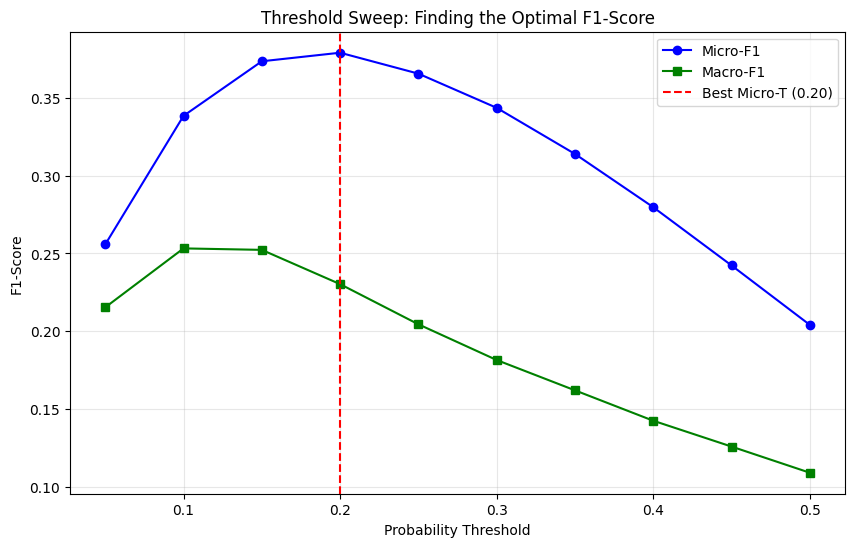


 Suggested Optimal Threshold: 0.2


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def find_best_threshold(y_true, y_probs):
    thresholds = np.arange(0.05, 0.55, 0.05)
    micro_f1s = []
    macro_f1s = []

    print("Testing thresholds...")
    for t in thresholds:
        y_pred = (y_probs > t).astype(int)
        micro = f1_score(y_true, y_pred, average='micro')
        macro = f1_score(y_true, y_pred, average='macro')
        micro_f1s.append(micro)
        macro_f1s.append(macro)
        print(f"Threshold: {t:.2f} | Micro-F1: {micro:.4f} | Macro-F1: {macro:.4f}")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, micro_f1s, marker='o', label='Micro-F1', color='blue')
    plt.plot(thresholds, macro_f1s, marker='s', label='Macro-F1', color='green')

    # Highlight the best micro-f1
    best_idx = np.argmax(micro_f1s)
    best_t = thresholds[best_idx]
    plt.axvline(best_t, color='red', linestyle='--', label=f'Best Micro-T ({best_t:.2f})')

    plt.title('Threshold Sweep: Finding the Optimal F1-Score')
    plt.xlabel('Probability Threshold')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return best_t

# Run the sweep
best_threshold = find_best_threshold(y_test, y_probs)
print(f"\n Suggested Optimal Threshold: {best_threshold}")

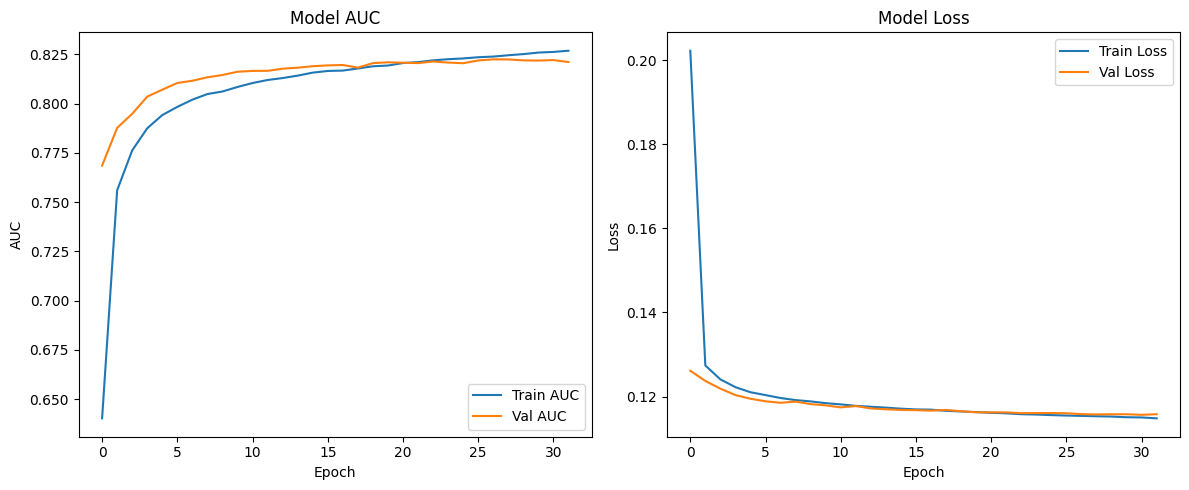

Generating predictions for the Test Set...
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
----------------------------------------
TEST SET EVALUATION (Threshold: 0.2)
Hamming Score (Accuracy): 0.2305 (Partial credit)
Macro-F1 Score: 0.2303
Micro-F1 Score: 0.3791
----------------------------------------
Top Category Performance (Sample):
              precision    recall  f1-score   support

        A419     0.3079    0.4565    0.3678       230
       B1920     0.3571    0.2362    0.2844       127
       B9620     0.3165    0.1351    0.1894       185
       B9689     0.0000    0.0000    0.0000       106
        C787     0.3533    0.5464    0.4291        97
       C7951     0.4206    0.6163    0.5000        86
        D509     0.3714    0.0607    0.1044       214
         D62     0.4920    0.6998    0.5778       573
        D631     0.3653    0.5545    0.4404       110
        D638     0.0000    0.0000    0.0000       110
        D649     0.2442    0.1679    0.1989       560
        D684     

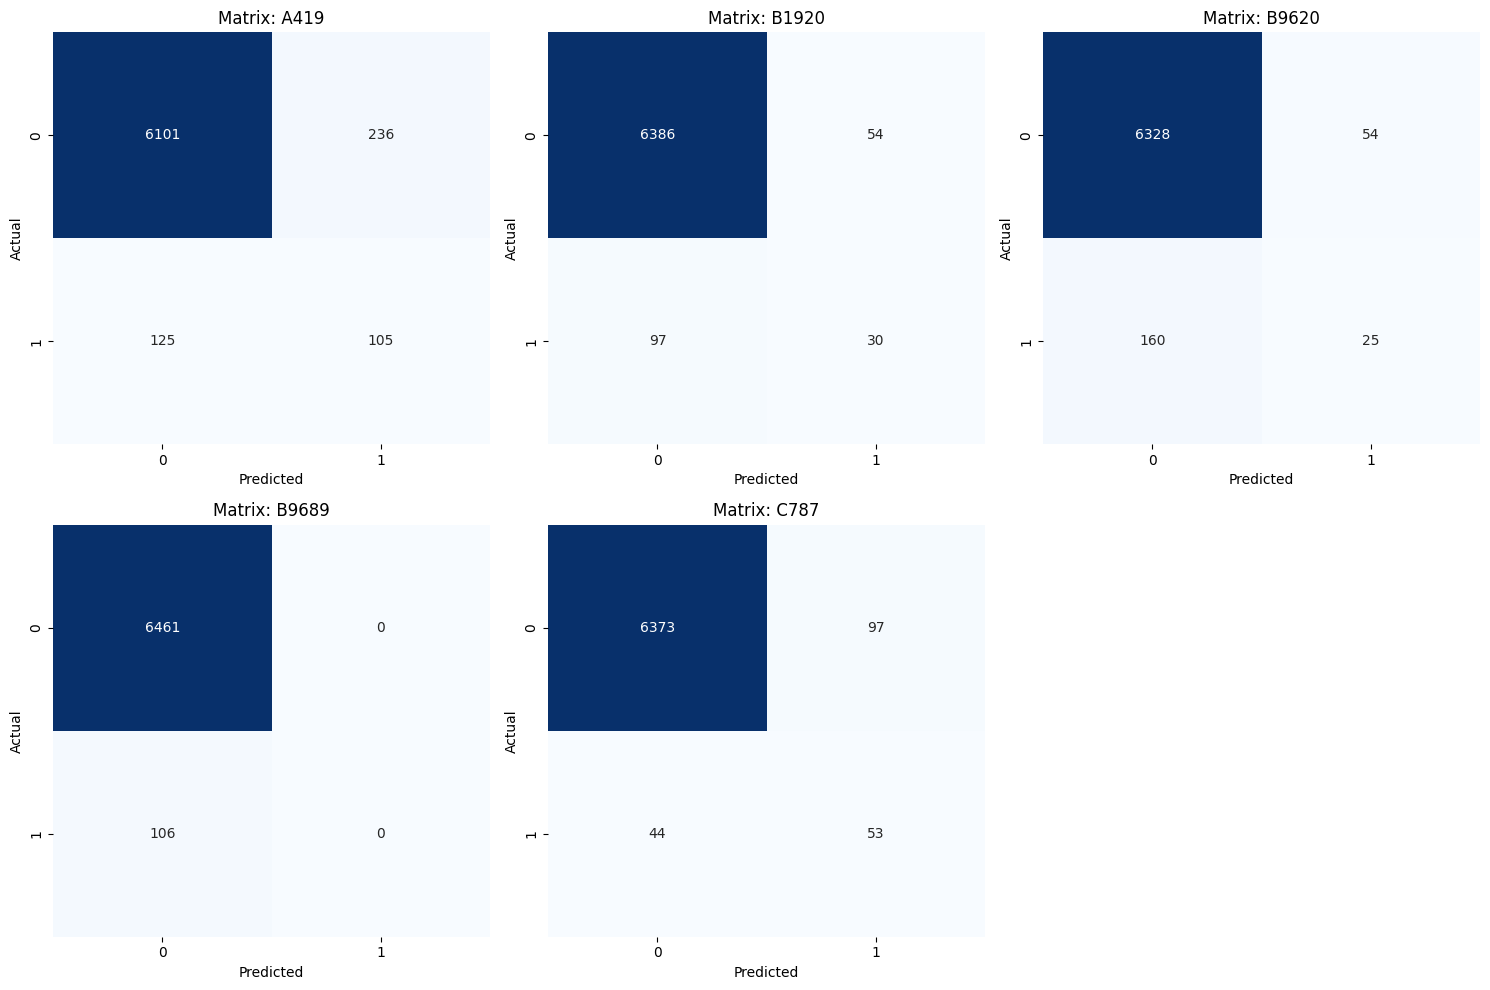

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, f1_score, accuracy_score, multilabel_confusion_matrix)

# 1. Plot Training Curves (Same as before)
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

# 2. Run Predictions
print("Generating predictions for the Test Set...")
y_probs = model.predict(X_test_emb)
threshold = 0.2
y_pred = (y_probs > threshold).astype(int)



# Hamming Score: Average overlap (Intersection over Union) - The "Fair" Accuracy
def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i] == 1)[0] )
        set_pred = set( np.where(y_pred[i] == 1)[0] )
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred)) / float(len(set_true.union(set_pred)))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

h_score = hamming_score(y_test, y_pred)

# 4. Global Metrics Printout
macro_f1 = f1_score(y_test, y_pred, average='macro')
micro_f1 = f1_score(y_test, y_pred, average='micro')

print("-" * 40)
print(f"TEST SET EVALUATION (Threshold: {threshold})")
print(f"Hamming Score (Accuracy): {h_score:.4f} (Partial credit)")
print(f"Macro-F1 Score: {macro_f1:.4f}")
print(f"Micro-F1 Score: {micro_f1:.4f}")
print("-" * 40)

# 5. Detailed Classification Report
report = classification_report(
    y_test, y_pred, target_names=mlb.classes_, digits=4, zero_division=0
)
print("Top Category Performance (Sample):")
print("\n".join(report.split("\n")[:25]))

# 6. Confusion Matrices for Top 5
def plot_top_confusion_matrices(y_true, y_pred, classes, n=5):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 10))
    for i in range(n):
        plt.subplot(2, 3, i+1)
        sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Matrix: {classes[i]}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

plot_top_confusion_matrices(y_test, y_pred, mlb.classes_)